In [1]:
# import dependencies
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T # for later data augmentation
from typing import Sequence
from torch.nn import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,  DataLoader, TensorDataset

In [2]:
# for better visualization during preprocessing, we view tensors and PIL images
t2img = T.ToPILImage() # tensor to pil image
img2t = T.ToTensor() # pil image to tensor

In [3]:
print(f"Cuda: {torch.cuda.is_available()}")

Cuda: True


In [4]:
working_dir = './'

# Useful tool functions

In [7]:
# save model status and checkpoint
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))

# get the current device: cpu or gpu
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
# If map_location is a torch.device object or a string containing a device tag, it indicates the location where all tensors should be loaded.
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# send tensor and model to the device
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

# get the total number of parameters of the model
def get_model_parameters(m): # numel: total number of elements
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

# print the total number of parameters
def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

In [8]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In the benchmark model, we use all the images, we ignore the existence of the ground truth masks

# Model 2: benchmark model with preprocessing for imbalanced dataset

## Dataset Creation

We take all the jpg pictures, and put them in a huge array to be the dataset.

We then do a train-test split, and create a dataloader for each of them.

In [9]:
# read the images according to the order of the dataframe image name

# read the metadata
meta_data_train = pd.read_csv('./data/metadataTrain.csv')
y = meta_data_train['CLASS'].values
y = y-1

# get the image names
image_names = list(meta_data_train['ID'].values)

In [10]:
all_images = []
for image in image_names:
    image_path = f'./data/Train/Train/{image}.jpg'
    image = Image.open(image_path)
    image_array = np.array(image)
    all_images.append(image_array)
    # print(image_array.shape)
print(len(all_images))

18998


We then realize that the images have different sizes, so we need to resize them to the same size.

In [11]:
# we will make all the images into the size of 512*512, which is the largest size, for those who are smaller, we use zero padding, there is not larger images
# write a loop to resize all the image arrays
all_images_pad = []
for i in range(len(all_images)):
    h, w, _ = all_images[i].shape
    # Initialize a new array of zeros of shape (512, 512, 3) for padding
    padded_image = np.zeros((512, 512, 3), dtype=all_images[0].dtype)

    # Calculate padding sizes
    pad_h = (512 - h) // 2
    pad_w = (512 - w) // 2

    # Update the padded_image with the original image centered
    padded_image[pad_h:pad_h+h, pad_w:pad_w+w, :] = all_images[i]

    # Append the padded image to the list
    all_images_pad.append(padded_image)
    if i % 5000 == 0:
        print(f"{i} images have been padded")


0 images have been padded
5000 images have been padded
10000 images have been padded
15000 images have been padded


We take a look at the padded images to see if they are correctly padded.

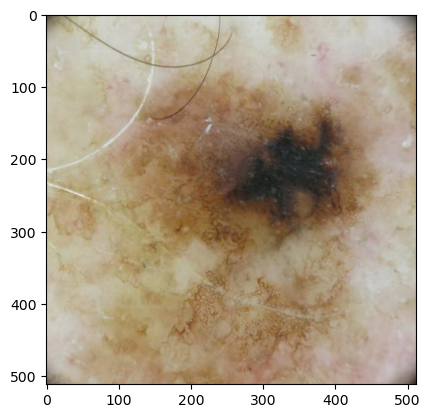

In [16]:
# view the padded images
plt.imshow(all_images_pad[90])

In [17]:
# reduce the resolution of the images to 128*128
all_images_pad = np.array([np.array(Image.fromarray(image).resize((128, 128))) for image in all_images_pad])

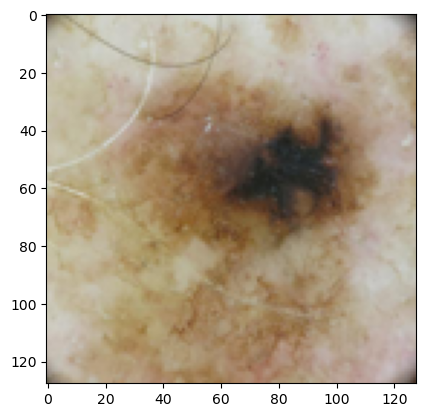

In [18]:
# view the images after resizing
plt.imshow(all_images_pad[90])

## Address the data imbalance issue

(array([3391., 9657., 2492.,  650., 1968.,  179.,  190.,  471.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

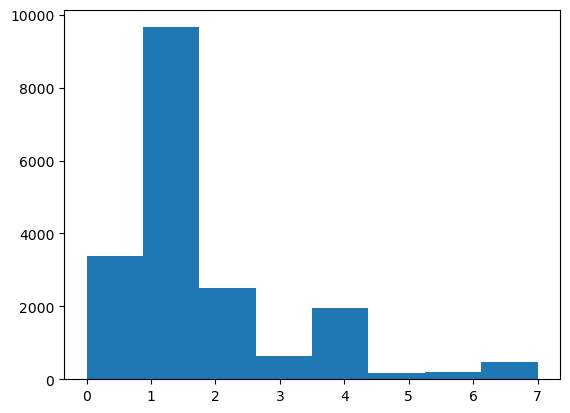

In [19]:
# take a look at the distribution of the classes
plt.hist(y, bins=8)

We first separate the training and testing dataset, and then we will use the training dataset to augment the underpresented classes.

In [20]:
# separate the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(all_images_pad, y, test_size=0.15, random_state=42, shuffle=True)

We can see that the dataset is imbalanced, we need to address this issue. We will augment the underpresented classes by rotation, translation, and flipping.

In [21]:
# we will use the torchvision.transforms to augment the images
image_transforms = T.Compose([
    T.RandomHorizontalFlip(), # probability of getting flipped is default to 0.5
    T.RandomVerticalFlip(),
    T.RandomRotation(45),
    T.RandomAffine(0, translate=(0.1, 0.1)),
    T.ToTensor(),
])

In [22]:
# apply the transformations to the images, and along with their labels, we add them to the training set
# we will use the CustomImageDataset class to create the dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_arrays, labels, transform=None):
        """
        Args:
            image_arrays (np.array): An array of Numpy arrays representing the images.
            labels (np.array): An array of labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_arrays = image_arrays
        # Ensure labels are in a compatible format (np.array or list)
        self.labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
        self.transform = transform

    def __len__(self):
        return len(self.image_arrays)

    def __getitem__(self, idx):
        image = self.image_arrays[idx]

        # Convert image from numpy array to PIL Image to apply torchvision transforms
        image = Image.fromarray(image.astype('uint8'), 'RGB')  # Ensure the data type and mode are correct

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

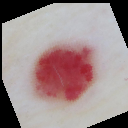

In [25]:
# apply the transformations to the 1 image and have a look
# put the image into PIL format first
image_sample = Image.fromarray(X_train[15000].astype('uint8'), 'RGB')
image_sample = image_transforms(image_sample)
t2img(image_sample)

In [30]:
# we get the number of images in the most presented class
max_number_class = pd.Series(y).value_counts().max()

In [50]:
pd.Series(y).value_counts()

1    9657
0    3391
2    2492
4    1968
3     650
7     471
6     190
5     179
Name: count, dtype: int64

In [45]:
max_number_class

9657

In [31]:
# we generate the lack of images for each class
lack_images = max_number_class - pd.Series(y).value_counts()
lack_images

1       0
0    6266
2    7165
4    7689
3    9007
7    9186
6    9467
5    9478
Name: count, dtype: int64

In [32]:
lack_images[0]

6266

In [40]:
# we will augment the images for each class
# retrieve the data in each class, and augment the data
# class 0
class_0 = X_train[y_train == 0]
# create a list to store the augmented images for class 0
augmented_class_0 = []
for i in range(lack_images[0]):
    image = Image.fromarray(class_0[i%len(class_0)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_0.append(image)
# do the same for the other classes
# class 2
class_2 = X_train[y_train == 2]
augmented_class_2 = []
for i in range(lack_images[2]):
    image = Image.fromarray(class_2[i%len(class_2)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_2.append(image)
# class 3
class_3 = X_train[y_train == 3]
augmented_class_3 = []
for i in range(lack_images[3]):
    image = Image.fromarray(class_3[i%len(class_3)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_3.append(image)
# class 4
class_4 = X_train[y_train == 4]
augmented_class_4 = []
for i in range(lack_images[4]):
    image = Image.fromarray(class_4[i%len(class_4)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_4.append(image)
# class 5
class_5 = X_train[y_train == 5]
augmented_class_5 = []
for i in range(lack_images[5]):
    image = Image.fromarray(class_5[i%len(class_5)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_5.append(image)
# class 6
class_6 = X_train[y_train == 6]
augmented_class_6 = []
for i in range(lack_images[6]):
    image = Image.fromarray(class_6[i%len(class_6)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_6.append(image)
# class 7
class_7 = X_train[y_train == 7]
augmented_class_7 = []
for i in range(lack_images[7]):
    image = Image.fromarray(class_7[i%len(class_7)].astype('uint8'), 'RGB')
    image = image_transforms(image)
    augmented_class_7.append(image)

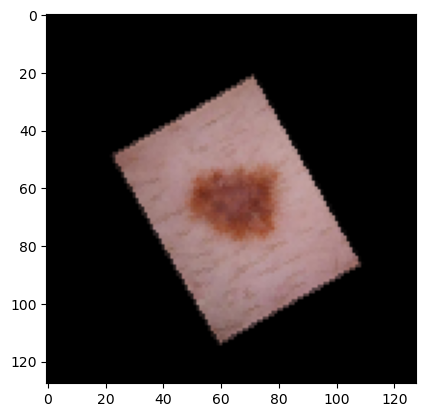

In [41]:
# check the dimension of images in the augmented_class_0
augmented_class_0[0].shape
# we need to put into the same dimension as the original images (128,128,3) and as numpy arrays
augmented_class_0 = [np.array(img).T for img in augmented_class_0]
# have a look at one of the augmented images
plt.imshow(augmented_class_0[0])

In [42]:
# do the same for the other classes
augmented_class_2 = [np.array(img).T for img in augmented_class_2]
augmented_class_3 = [np.array(img).T for img in augmented_class_3]
augmented_class_4 = [np.array(img).T for img in augmented_class_4]
augmented_class_5 = [np.array(img).T for img in augmented_class_5]
augmented_class_6 = [np.array(img).T for img in augmented_class_6]
augmented_class_7 = [np.array(img).T for img in augmented_class_7]

In [47]:
# print the length of the augmented list
len(augmented_class_2)

7165

In [48]:
lack_images

1       0
0    6266
2    7165
4    7689
3    9007
7    9186
6    9467
5    9478
Name: count, dtype: int64

In [43]:
# add the augmented images to X_train and their labels to y_train
X_train_augmented = np.concatenate((X_train, [np.array(img) for img in augmented_class_0], [np.array(img) for img in augmented_class_2], [np.array(img) for img in augmented_class_3], [np.array(img) for img in augmented_class_4], [np.array(img) for img in augmented_class_5], [np.array(img) for img in augmented_class_6], [np.array(img) for img in augmented_class_7]), axis=0)
y_train_augmented = np.concatenate((y_train, [0]*lack_images[0], [2]*lack_images[2], [3]*lack_images[3], [4]*lack_images[4], [5]*lack_images[5], [6]*lack_images[6], [7]*lack_images[7]), axis=0)

(array([9140., 8223., 9279., 9555., 9366., 9628., 9627., 9588.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

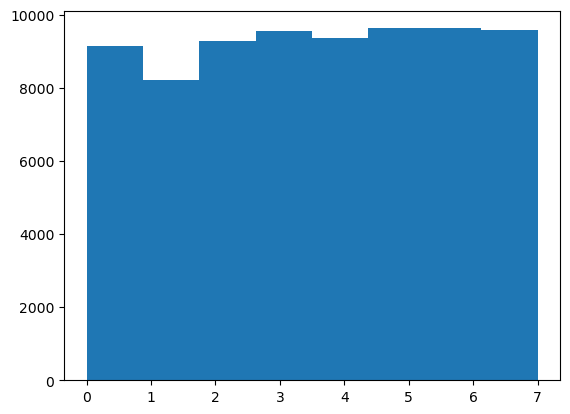

In [44]:
# we now have a look at the distribution of the classes
plt.hist(y_train_augmented, bins=8)

In [51]:
# put the data into dataloaders

transform = T.Compose([
    T.ToTensor(),
])

dataset_train = CustomImageDataset(X_train_augmented, y_train_augmented, transform=transform)
dataset_test = CustomImageDataset(X_test, y_test, transform=transform)

batch_size = 32  # Define your batch size

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [53]:
(train_inputs_0, train_targets_0) = next(iter(dataloader_train))
(test_inputs, test_targets) = next(iter(dataloader_test))

## Build the Beginner Model


In [52]:
class BeginnerModel(nn.Module):
    def __init__(self, n_classes=8, in_pixel=128):
        super(BeginnerModel, self).__init__()
        self.in_pixel = in_pixel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # RGB channels as input
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * (self.in_pixel//8) * (self.in_pixel//8), n_classes)  # in_pixel//8 because of 3 maxpool layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * (self.in_pixel//8) * (self.in_pixel//8))
        x = self.fc1(x)
        return x

In [54]:
# define the model
m = BeginnerModel(n_classes=8)
m.eval()
to_device(m)
m(to_device(train_inputs_0)).shape # input the first batch to test

torch.Size([32, 8])

## simple training function

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_device(m)

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)  # Optimizer

num_epochs = 10  # Number of epochs to train for

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        print(f'Epoch {epoch+1}')
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Train the model
train_model(m, dataloader_train, criterion, optimizer, num_epochs, device)

Epoch 1
Epoch [1/10], Loss: 1.7894
Epoch 2
Epoch [2/10], Loss: 1.7587
Epoch 3
Epoch [3/10], Loss: 1.7409
Epoch 4
Epoch [4/10], Loss: 1.7273
Epoch 5
Epoch [5/10], Loss: 1.7152
Epoch 6
Epoch [6/10], Loss: 1.7025
Epoch 7
Epoch [7/10], Loss: 1.6956
Epoch 8
Epoch [8/10], Loss: 1.6780
Epoch 9
Epoch [9/10], Loss: 1.6681
Epoch 10
Epoch [10/10], Loss: 1.6541


In [56]:
# get the precision of the prediction from the test dataloader
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    accuracy = running_corrects / len(test_loader.dataset)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

In [57]:
test_model(m, dataloader_test, criterion, device)

Loss: 1.2126, Accuracy: 0.6288


In [58]:
# train another 10 epochs
train_model(m, dataloader_train, criterion, optimizer, num_epochs, device)

Epoch 1
Epoch [1/10], Loss: 1.6429
Epoch 2
Epoch [2/10], Loss: 1.6320
Epoch 3
Epoch [3/10], Loss: 1.6214
Epoch 4
Epoch [4/10], Loss: 1.6135
Epoch 5
Epoch [5/10], Loss: 1.6036
Epoch 6
Epoch [6/10], Loss: 1.5964
Epoch 7
Epoch [7/10], Loss: 1.5895
Epoch 8
Epoch [8/10], Loss: 1.5815
Epoch 9
Epoch [9/10], Loss: 1.5777
Epoch 10
Epoch [10/10], Loss: 1.5725


In [59]:
test_model(m, dataloader_test, criterion, device)

Loss: 2.1428, Accuracy: 0.6119


In [73]:
# train another 20 epochs
train_model(m, dataloader_train, criterion, optimizer, 20, device)
test_model(m, dataloader_test, criterion, device)

Epoch 1
Epoch [1/20], Loss: 1.5677
Epoch 2
Epoch [2/20], Loss: 1.5652
Epoch 3
Epoch [3/20], Loss: 1.5719
Epoch 4
Epoch [4/20], Loss: 1.5665
Epoch 5
Epoch [5/20], Loss: 1.5577
Epoch 6
Epoch [6/20], Loss: 1.5546
Epoch 7
Epoch [7/20], Loss: 1.5536
Epoch 8
Epoch [8/20], Loss: 1.5511
Epoch 9
Epoch [9/20], Loss: 1.5484
Epoch 10
Epoch [10/20], Loss: 1.5496
Epoch 11
Epoch [11/20], Loss: 1.5442
Epoch 12
Epoch [12/20], Loss: 1.5487
Epoch 13
Epoch [13/20], Loss: 1.5423
Epoch 14
Epoch [14/20], Loss: 1.5435
Epoch 15
Epoch [15/20], Loss: 1.5411
Epoch 16
Epoch [16/20], Loss: 1.5423
Epoch 17
Epoch [17/20], Loss: 1.5424
Epoch 18
Epoch [18/20], Loss: 1.5392
Epoch 19
Epoch [19/20], Loss: 1.5378
Epoch 20
Epoch [20/20], Loss: 1.5363
Loss: 4.5126, Accuracy: 0.6049


In [81]:
# train another 40 epochs
train_model(m, dataloader_train, criterion, optimizer, 40, device)
test_model(m, dataloader_test, criterion, device)

Epoch 1
Epoch [1/40], Loss: 1.5401
Epoch 2
Epoch [2/40], Loss: 1.5374
Epoch 3
Epoch [3/40], Loss: 1.5392
Epoch 4
Epoch [4/40], Loss: 1.5385
Epoch 5
Epoch [5/40], Loss: 1.5357
Epoch 6
Epoch [6/40], Loss: 1.5364
Epoch 7
Epoch [7/40], Loss: 1.5364
Epoch 8
Epoch [8/40], Loss: 1.5352
Epoch 9


KeyboardInterrupt: 

## Use the model to predict submission dataset

In [74]:
meta_data_submission = pd.read_csv('./data/metadataTest.csv')
id_list = list(meta_data_submission['ID'].values)

In [75]:
all_images_submission = []
for image in id_list:
    image_path = f'./data/Test/Test/{image}.jpg'
    image = Image.open(image_path)
    image_array = np.array(image)
    all_images_submission.append(image_array)
    # print(image_array.shape)
print(len(all_images_submission))

6333


In [76]:
# we will make all the images into the size of 512*512, which is the largest size, for those who are smaller, we use zero padding, there is not larger images
# write a loop to resize all the image arrays
all_images_submission_pad = []
for i in range(len(all_images_submission)):
    h, w, _ = all_images_submission[i].shape
    # Initialize a new array of zeros of shape (512, 512, 3) for padding
    padded_image = np.zeros((512, 512, 3), dtype=all_images_submission[0].dtype)

    # Calculate padding sizes
    pad_h = (512 - h) // 2
    pad_w = (512 - w) // 2

    # Update the padded_image with the original image centered
    padded_image[pad_h:pad_h+h, pad_w:pad_w+w, :] = all_images_submission[i]

    # Append the padded image to the list
    all_images_submission_pad.append(padded_image)
    if i % 5000 == 0:
        print(f"{i} images have been padded")


0 images have been padded
5000 images have been padded


In [77]:
# reduce the resolution of the images to 128*128
all_images_submission_pad = np.array([np.array(Image.fromarray(image).resize((128, 128))) for image in all_images_submission_pad])

In [68]:
all_images_submission_pad.shape

(6333, 128, 128, 3)

ssh project 17

scp fhong-22@gpu5.enst.fr:/tmp/pycharm_project_17/classification_challenge/submission_benchmark.csv E:

In [78]:
# Assuming `data_array` is your numpy array of shape (6333, 128, 128, 3)
# and `model` is your trained PyTorch model

# Step 1: Convert the numpy array to a PyTorch tensor and transpose it to (Batch, Channels, Height, Width)
data_tensor = torch.tensor(all_images_submission_pad).float()
data_tensor = data_tensor.permute(0, 3, 1, 2)

# Step 2: Create a DataLoader
batch_size = 16  # You can adjust the batch size
dataset_submission = TensorDataset(data_tensor)
data_loader_submission = DataLoader(dataset_submission, batch_size=batch_size, shuffle=False)

# Step 3: Set the model to evaluation mode
m.eval()

# Prepare device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_device(m)

# Step 4: Generate Predictions
predictions = []
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in data_loader_submission:
        inputs = to_device(batch[0])
        # inputs = batch[0].to(device)
        outputs = m(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        predictions.extend(predicted.cpu().numpy())

In [79]:
predictions = [prediction+1 for prediction in predictions]

In [80]:
df_submission = pd.DataFrame({'ID': id_list, 'CLASS': predictions})
df_submission.to_csv('submission_benchmark.csv', index=False)

# draft